In [1]:
import h5py
import os
import seaborn as sns
import joblib
import copy
import cv2
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
from collections import OrderedDict

import habitat
from habitat.utils.visualizations import maps, utils

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
ACTUAL_ROUTE_COLOR = [0, 0, 200]  # Blue
VO_ROUTE_COLOR = (200, 0, 0)   # red

Assume the evaluation results are saved under `$SAVE_DIR`. Please assign `info_f` to the `$SAVE_DIR/infos/XX.infos.p`.

In [3]:
!ls /datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_014657546960/infos

eval_infos.p  rl_no_tune.infos.p  XX.infos.p


In [4]:
SAVE_DIR = "/datasets/home/memmel/PointNav-VO/pretrained_ckpts/rl/no_tune/seed_1-val-single_ckpt-train_noise_rgb_1_depth_1_act_1-eval_noise_rgb_1_depth_1_act_1-vo_regress_all_best-mode_det-rnd_n_10-20221108_020312782149/infos"
info_f = f"{SAVE_DIR}/XX.infos.p"
# info_f = f"{SAVE_DIR}/train_objective_info.p"

In [5]:
info_dict = joblib.load(open(info_f, "rb"))

In [6]:
info_dict

{'start': {'position': [0.47876065969467163,
   0.1582520604133606,
   -4.124194145202637],
  'rotation': [0, 0.13995857593396624, 0, 0.9901573597275012]},
 'goal': {'position': [-7.889715671539307,
   0.1582520604133606,
   -0.6258162260055542]},
 'stat': {'reward': 9.402496337890625,
  'distance_to_goal': 0.8524249792098999,
  'success': 0.0,
  'spl': 0.0,
  'softspl': 0.7620204803384857,
  'collisions.count': 35.0,
  'len': 106,
  'dx_stuck': 17,
  'dz_stuck': 17,
  'both_stuck': 17},
 'map': {'blank_top_down_map': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'ind_x_min': 0,
  'ind_x_max': 1249,
  'ind_y_min': 675,
  'ind_y_max': 1233,
  'grid_delta': 3,
  'coordinate_min': -13.564725875854492,
  'coordinate_max': 1.232903242111206,
  'map_resolution': (1250, 1250),
  'line_thickness': 12},
 'traj'

In [16]:
info_dict["stat"]

{'reward': 9.402496337890625,
 'distance_to_goal': 0.8524249792098999,
 'success': 0.0,
 'spl': 0.0,
 'softspl': 0.7620204803384857,
 'collisions.count': 35.0,
 'len': 106,
 'dx_stuck': 17,
 'dz_stuck': 17,
 'both_stuck': 17}

In [18]:
info_dict["traj"][0].keys()

dict_keys(['action', 'prev_agent_state', 'cur_agent_state', 'prev_agent_angle', 'cur_agent_angle', 'gt_delta', 'collision', 'fog_of_war_mask', 'rgb', 'depth', 'ego_top_down_map', 'pred_delta', 'prev_agent_state_from_vo', 'cur_agent_state_from_vo', 'vo_pred_std'])

In [11]:
def _get_map_coord(map_info, step_info, state_k):

    map_agent_x, map_agent_y = maps.to_grid(
        step_info[f"{state_k}"]["position"][0], # x
        step_info[f"{state_k}"]["position"][2], # z
        map_info["coordinate_min"],
        map_info["coordinate_max"],
        map_info["map_resolution"],
    )
    agent_map_coord = (
        map_agent_x - (map_info["ind_x_min"] - map_info["grid_delta"]),
        map_agent_y - (map_info["ind_y_min"] - map_info["grid_delta"]),
    )
    
    return agent_map_coord

In [25]:
def draw_traj_top_down_map(traj_info):
    
    N = 20
    
    print(traj_info["stat"]["spl"])
    
    map_info = traj_info["map"]
    top_down_map = map_info["blank_top_down_map"]
    top_down_map = maps.colorize_topdown_map(top_down_map)
    
    # print(top_down_map.shape)
    
    step_infos = traj_info["traj"]
    # print(len(step_infos))
    
    actual_map_coords = []
    imagine_map_coords = []
        
    for elem in step_infos:
        actual_map_coords.append(
            _get_map_coord(map_info, elem, "cur_agent_state")
        )
        imagine_map_coords.append(
            _get_map_coord(map_info, elem, "cur_agent_state_from_vo")
        )
        
    line_thickness = int( max(1, int(top_down_map.shape[0] / 40)) * 1 ) // 4
    agent_size = int(top_down_map.shape[0] / 30) * 1
    # print(line_thickness)
        
    # actual path
    maps.draw_path(
        top_down_map,
        actual_map_coords,
        ACTUAL_ROUTE_COLOR,
        line_thickness
    )
    
    # VO imagine path
    maps.draw_path(
        top_down_map,
        imagine_map_coords,
        VO_ROUTE_COLOR,
        line_thickness
    )
    
    # blue
    source_square = np.zeros((agent_size * 2, agent_size * 2, 3))
    source_square[:, :, 2] = 255
    source_map_coord = _get_map_coord(map_info, {"placeholder": traj_info["start"]}, "placeholder")
    
    utils.paste_overlapping_image(top_down_map, source_square, source_map_coord)
    
    # green
    goal_square = np.zeros((agent_size * 2, agent_size * 2, 3))
    goal_square[:, :, 1] = 255
    goal_map_coord = _get_map_coord(map_info, {"placeholder": traj_info["goal"]}, "placeholder")
    
    utils.paste_overlapping_image(top_down_map, goal_square, goal_map_coord)
    
    # draw agent's position
    top_down_map = maps.draw_agent(
        top_down_map,
        actual_map_coords[-1],
        # heading - np.pi / 2,
        step_infos[-1][f"cur_agent_angle"],
        agent_radius_px=agent_size,
    )
    
    if top_down_map.shape[0] > top_down_map.shape[1]:
        # top_down_map = np.transpose(top_down_map, (1, 0, 2))
        top_down_map = np.rot90(top_down_map, 1)
    
    # print(top_down_map.shape)
    
    top_down_map_img = Image.fromarray(top_down_map)
    plt.imshow(top_down_map_img)
    top_down_map_img.save("./top_down_map.pdf")

0.0


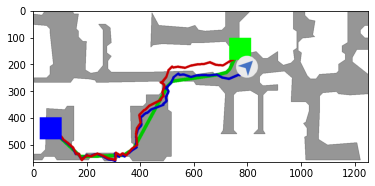

In [26]:
# traj_step_infos = info_dict[list(info_dict.keys())[1]]["2"]
traj_step_infos = info_dict

draw_traj_top_down_map(traj_step_infos)

In [14]:
info_dict.keys()

dict_keys(['start', 'goal', 'stat', 'map', 'traj', 'vo_l2_loss', 'diff_between_global_states'])